In [ ]:
#first import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model

#import time
import time

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import cv2
import random
import os

print("TensorFlow:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

TensorFlow: 2.20.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [29]:
#get the images directory
image_dir = os.getcwd() + '/images/finding_waldo'

#get the background and waldo image directory
background_dir = image_dir + '/wheres_wally.jpg'
waldo_dir = image_dir + '/waldo.png'

waldo_path = waldo_dir
background_path = background_dir


waldo_png = Image.open(waldo_path).convert("RGBA")
background_img = Image.open(background_path).convert("RGB")


# training image resolution
BG_W, BG_H = 500, 350

# Waldo sprite size (for training)
WALDO_W, WALDO_H = 60, 100
waldo_png = waldo_png.resize((WALDO_W, WALDO_H), Image.LANCZOS)

In [30]:
def jitter(im):
    im = ImageEnhance.Brightness(im).enhance(np.random.uniform(0.9, 1.1))
    im = ImageEnhance.Contrast(im).enhance(np.random.uniform(0.9, 1.1))
    return im

def generate_training_sample():
    bg = jitter(background_img.resize((BG_W, BG_H)).copy())

    # 50% chance of including Waldo
    if random.random() < 0.5:
        w = waldo_png.copy()
        
        # random flip
        if random.random() < 0.5:
            w = ImageOps.mirror(w)
        
        # slight rotation
        angle = random.uniform(-8, 8)
        w = w.rotate(angle, resample=Image.BICUBIC, expand=False)
        
        # random placement
        x = random.randint(0, BG_W - WALDO_W)
        y = random.randint(0, BG_H - WALDO_H)
        
        bg.paste(w, (x, y), w)
        box = np.array([x, y, x + WALDO_W, y + WALDO_H], dtype=np.float32)
        cls = np.array([1.0], dtype=np.float32)
    else:
        # NEGATIVE EXAMPLE — no Waldo
        box = np.array([0, 0, 0, 0], dtype=np.float32)
        cls = np.array([0.0], dtype=np.float32)

    arr = np.array(bg).astype(np.float32) / 255.0
    return arr, box, cls

def data_generator(batch_size=16):
    while True:
        X = np.zeros((batch_size, BG_H, BG_W, 3), np.float32)
        y_box = np.zeros((batch_size, 4), np.float32)
        y_cls = np.zeros((batch_size, 1), np.float32)
        
        for i in range(batch_size):
            img, box, cls = generate_training_sample()
            X[i] = img
            y_box[i] = box
            y_cls[i] = cls
        
        yield X, {"class_output": y_cls, "box_output": y_box}

In [31]:
inputs = layers.Input((BG_H, BG_W, 3))

x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 6, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 6, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(2)(x)

feat = x

# Classification head
c = layers.Flatten()(feat)
c = layers.Dense(1024, activation='relu')(c)
c = layers.Dense(512, activation='relu')(c)
class_output = layers.Dense(1, activation='sigmoid', name='class_output')(c)

# Bounding box head
b = layers.Flatten()(feat)
b = layers.Dense(1024, activation='relu')(b)
b = layers.Dense(512, activation='relu')(b)
box_output = layers.Dense(4, name='box_output')(b)  # x1,y1,x2,y2

model = models.Model(inputs=inputs, outputs=[class_output, box_output])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 350, 500,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 350, 500,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 350, 500,  │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 175, 250,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 175, 250,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 250,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 87, 125,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 82, 120,   │     73,792 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 82, 120,   │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 41, 60,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 36, 55,    │    147,520 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 36, 55,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 18, 27,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 31104)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 31104)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │ 31,851,520 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │ 31,851,520 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    524,800 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 64,982,309 (247.89 MB)

 Trainable params: 64,981,957 (247.89 MB)

 Non-trainable params: 352 (1.38 KB)

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "class_output": "binary_crossentropy",
        "box_output": "mse"
    },
    loss_weights={
        "class_output": 1.0,
        "box_output": 5.0
    },
    metrics={
        "class_output": "accuracy",
        "box_output": "mse"
    }
)

In [33]:
BATCH = 16

history = model.fit(
    data_generator(BATCH),
    steps_per_epoch=100,
    epochs=5,
    verbose=1
)

model.save("waldo_detector.keras")
print("Saved waldo_detector.keras")

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - box_output_loss: 12733.4404 - box_output_mse: 12733.4404 - class_output_accuracy: 0.6587 - class_output_loss: 2.9583 - loss: 63670.1602
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 900ms/step - box_output_loss: 1436.0021 - box_output_mse: 1436.0021 - class_output_accuracy: 0.9894 - class_output_loss: 0.0387 - loss: 7180.0488
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 871ms/step - box_output_loss: 557.0576 - box_output_mse: 557.0576 - class_output_accuracy: 0.9906 - class_output_loss: 0.0339 - loss: 2785.3213
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 87s 872ms/step - box_output_loss: 319.3446 - box_output_mse: 319.3446 - class_output_accuracy: 0.9831 - class_output_loss: 0.0516 - loss: 1596.7756
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 876ms/step - box_output_loss: 201.5400 - box_output_mse: 201.5400 - class_output_accuracy: 0.9594 - class_output_loss: 0.3470 - loss: 1008.0469
Saved waldo_detector.keras


In [34]:
# save
model.save("waldo_detector.keras")

# load later
import tensorflow as tf
model = tf.keras.models.load_model("waldo_detector.keras")

In [35]:
def clamp_box(box, W, H):
    x1, y1, x2, y2 = [float(v) for v in box]
    x1 = max(0, min(W-1, x1))
    y1 = max(0, min(H-1, y1))
    x2 = max(0, min(W-1, x2))
    y2 = max(0, min(H-1, y2))
    if x2 <= x1: x2 = x1 + 1
    if y2 <= y1: y2 = y1 + 1
    return int(x1), int(y1), int(x2), int(y2)

def plausible(box, W, H):
    x1, y1, x2, y2 = box
    area = (x2-x1)*(y2-y1)
    rel = area/(W*H)
    return 0.002 < rel < 0.5

In [47]:
from PIL import Image

def make_test_image_with_waldo(out_path="test_waldo_image.jpg", x=200, y=120):
    # Start from EXACT SAME background used in training:
    bg = background_img.resize((BG_W, BG_H)).copy()
    
    # Waldo sprite resized EXACTLY like training:
    waldo = waldo_png.resize((WALDO_W, WALDO_H), Image.LANCZOS)
    
    # Paste Waldo into the image
    bg.paste(waldo, (x, y), waldo)
    
    # Save output
    bg.save(out_path)
    return out_path

test_path = make_test_image_with_waldo()
print(test_path)

test_waldo_image.jpg


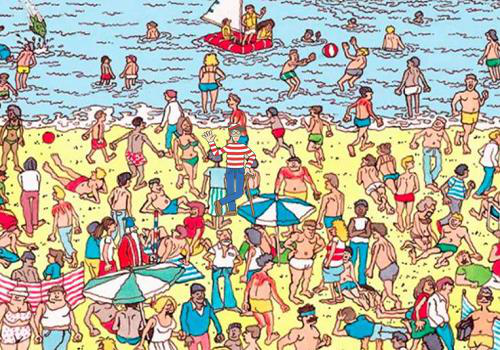

In [48]:
from IPython.display import display
display(Image.open("test_waldo_image.jpg"))

In [49]:
def detect_waldo_in_page(path, conf_thr=0.7):
    img = Image.open(path).convert("RGB")
    W, H = img.size
    

    resized = img.resize((BG_W, BG_H))
    X = (np.array(resized)/255.0)[None]
    cls_pred, box_pred = model.predict(X, verbose=0)

    x1,y1,x2,y2 = box_pred[0]
    x1,y1,x2,y2 = clamp_box([x1,y1,x2,y2], BG_W, BG_H)

    # If image is already model size do NOT rescale!
    if (img.width, img.height) == (BG_W, BG_H):
        X1,Y1,X2,Y2 = int(x1),int(y1),int(x2),int(y2)
    else:
        sx, sy = img.width/BG_W, img.height/BG_H
        X1,Y1,X2,Y2 = int(x1*sx),int(y1*sy),int(x2*sx),int(y2*sy)

    conf = float(cls_pred[0][0])
    x1, y1, x2, y2 = box_pred[0]
    
    # clamp in resized space
    x1, y1, x2, y2 = clamp_box([x1,y1,x2,y2], BG_W, BG_H)
    
    # map back to original page coords
    sx, sy = W/BG_W, H/BG_H
    X1, Y1, X2, Y2 = clamp_box([x1*sx, y1*sy, x2*sx, y2*sy], W, H)
    
    out = np.array(img).copy()
    
    if conf >= conf_thr and plausible((X1,Y1,X2,Y2), W, H):
        cv2.rectangle(out, (X1,Y1), (X2,Y2), (255,0,0), 4)
        title = f"DETECTED (conf={conf:.2f})"
    else:
        title = f"NO WALDO (conf={conf:.2f})"
    
    plt.figure(figsize=(10,8))
    plt.imshow(out)
    plt.axis("off")
    plt.title(title)
    
    return conf, (X1,Y1,X2,Y2), title

In [50]:
def make_test_image_with_waldo(out="test_present.jpg"):
    bg = background_img.resize((BG_W, BG_H)).copy()
    bg.paste(waldo_png, (200, 140), waldo_png)
    bg.save(out)
    return out

def make_test_image_no_waldo(out="test_absent.jpg"):
    bg = background_img.resize((BG_W, BG_H)).copy()
    bg.save(out)
    return out

(1.0, (69, 80, 107, 122), 'DETECTED (conf=1.00)')

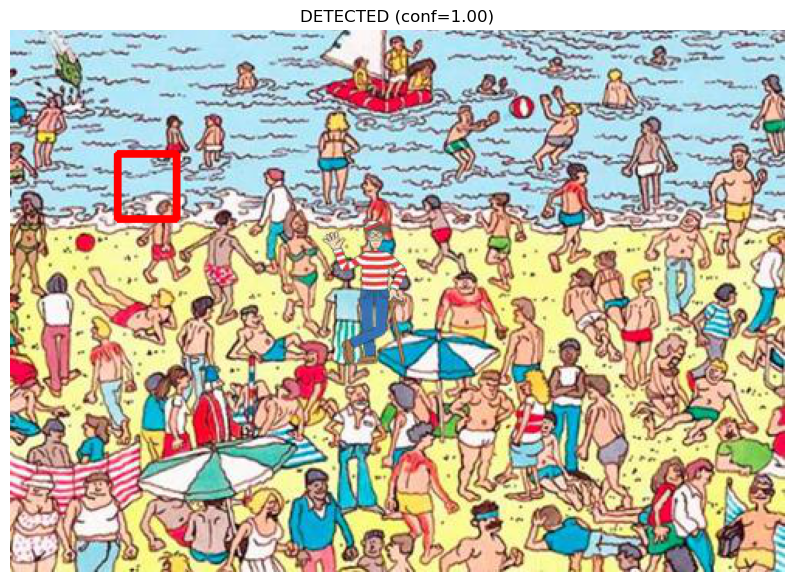

In [55]:
detect_waldo_in_page("test_waldo_image.jpg")

Negative Test:


(0.14925408363342285, (34, 94, 67, 131), 'NO WALDO (conf=0.15)')

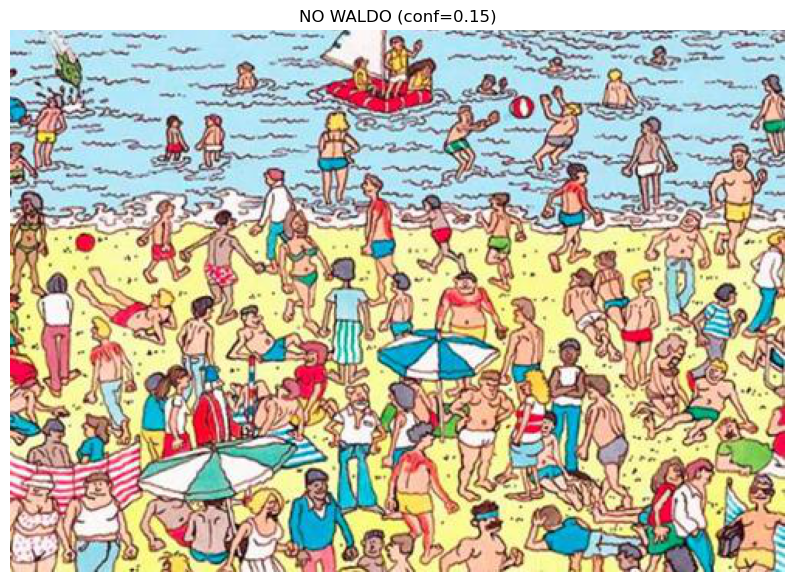

In [42]:
print("Negative Test:")
detect_waldo_in_page(make_test_image_no_waldo())

(0.04115075618028641, (33, 96, 66, 137), 'NO WALDO (conf=0.04)')

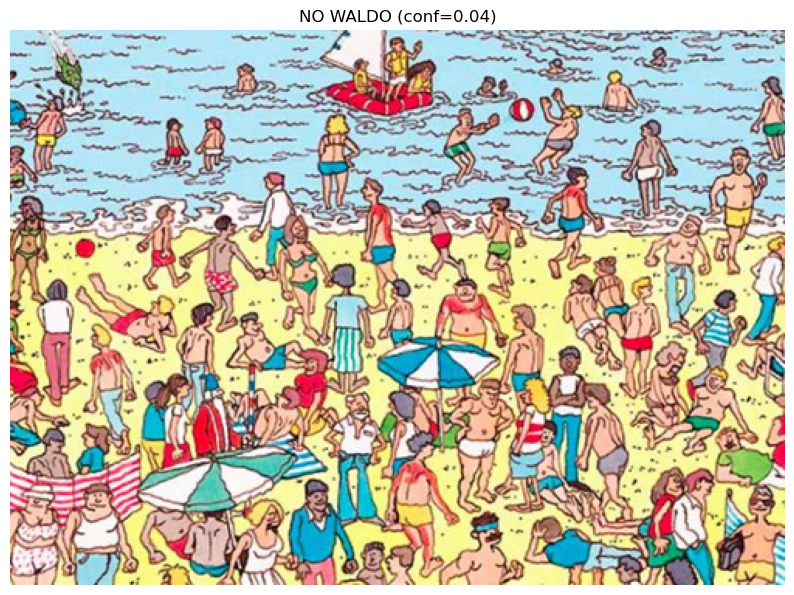

In [40]:
detect_waldo_in_page(background_dir)